# Week 10-9 다측면 감성 분석(RNN)

In [1]:
# 데이터 읽기

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

os.chdir(r'C:\Users\USER\kjw\LG전자_25\Week10')
review_df=pd.read_csv("thinq_e_review_result.csv")

review_df

date  star   like  \
0      September 18, 2021     1   12.0   
1      September 19, 2021     1    NaN   
2      September 18, 2021     2    6.0   
3      September 18, 2021     1    2.0   
4       September 1, 2021     1  104.0   
...                   ...   ...    ...   
11275        June 6, 2019     5    NaN   
11276    November 9, 2020     5    NaN   
11277       July 17, 2020     5    NaN   
11278  September 27, 2020     1    NaN   
11279     January 1, 2021     1    NaN   

                                                 comment  \
0      This app no longer works. It has just updated ...   
1      Everything worked fine until a week or so ago....   
2      App doesn't work with wired TV connection. EDI...   
3      I'm trying this again by have Alexa connection...   
4      Just embarrassing. Absolutely, 100%, will not ...   
...                                                  ...   
11275                            Good app. useful so far   
11276           Its been helpful. Hope it stays that way   
11277  Worked like it should and gave me feedback tha...   
11278                            error routed device.. .   
11279               Not connected with washing machine 😞   

                                               comment_n  
0      ['app', 'longer', 'work', 'updated', 'tell', '...  
1      ['everything', 'worked', 'fine', 'week', 'ago'...  
2      ['app', 'work', 'wired', 'tv', 'connection', '...  
3      ['trying', 'alexa', 'connection', 'turn', 'lg'...  
4      ['embarrassing', 'absolutely', 'connect', 'goo...  
...                                                  ...  
11275                   ['good', 'app', 'useful', 'far']  
11276                 ['helpful', 'hope', 'stay', 'way']  
11277  ['worked', 'like', 'gave', 'feedback', 'wanting']  
11278                      ['error', 'routed', 'device']  
11279                ['connected', 'washing', 'machine']  

[11280 rows x 5 columns]

In [2]:
# 목표 변수 만들기(이전 예제와 동일)
del_index=review_df[review_df['star']==3].index
review_df.drop(del_index,axis=0,inplace=True)
review_df.shape

(10153, 5)

In [3]:
review_df['sentiment']=review_df['star'].apply(lambda x: 1 if x>=4 else 0)
review_df

date  star   like  \
0      September 18, 2021     1   12.0   
1      September 19, 2021     1    NaN   
2      September 18, 2021     2    6.0   
3      September 18, 2021     1    2.0   
4       September 1, 2021     1  104.0   
...                   ...   ...    ...   
11275        June 6, 2019     5    NaN   
11276    November 9, 2020     5    NaN   
11277       July 17, 2020     5    NaN   
11278  September 27, 2020     1    NaN   
11279     January 1, 2021     1    NaN   

                                                 comment  \
0      This app no longer works. It has just updated ...   
1      Everything worked fine until a week or so ago....   
2      App doesn't work with wired TV connection. EDI...   
3      I'm trying this again by have Alexa connection...   
4      Just embarrassing. Absolutely, 100%, will not ...   
...                                                  ...   
11275                            Good app. useful so far   
11276           Its been helpful. Hope it stays that way   
11277  Worked like it should and gave me feedback tha...   
11278                            error routed device.. .   
11279               Not connected with washing machine 😞   

                                               comment_n  sentiment  
0      ['app', 'longer', 'work', 'updated', 'tell', '...          0  
1      ['everything', 'worked', 'fine', 'week', 'ago'...          0  
2      ['app', 'work', 'wired', 'tv', 'connection', '...          0  
3      ['trying', 'alexa', 'connection', 'turn', 'lg'...          0  
4      ['embarrassing', 'absolutely', 'connect', 'goo...          0  
...                                                  ...        ...  
11275                   ['good', 'app', 'useful', 'far']          1  
11276                 ['helpful', 'hope', 'stay', 'way']          1  
11277  ['worked', 'like', 'gave', 'feedback', 'wanting']          1  
11278                      ['error', 'routed', 'device']          0  
11279                ['connected', 'washing', 'machine']          0  

[10153 rows x 6 columns]

<AxesSubplot:>

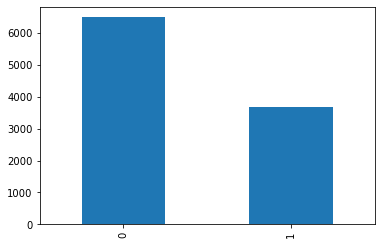

In [4]:
# 목표 변수 분포
review_df['sentiment'].value_counts().plot(kind='bar')

In [5]:
review_df['comment_n']=review_df['comment_n'].apply(lambda x: eval(x))

In [6]:
review_df['comment_n_str']=review_df['comment_n'].apply(lambda x: ' '.join(x))

In [7]:
# 입력 변수와 출력 변수 분리
X_data = review_df['comment_n_str']
y_data = review_df['sentiment']

In [8]:
# 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)
print(sequences)

[[1, 211, 4, 220, 105, 153, 931, 647, 453, 105, 49, 114, 153, 453, 704, 253, 999, 49, 739, 660, 4, 94, 1752, 13, 1080, 6, 5], [131, 107, 94, 247, 476, 9, 267, 197, 73, 623, 55, 412, 4, 454, 108, 83, 69, 284, 454, 83, 1937, 131, 35, 94, 599, 284, 69, 6, 5], [1, 4, 1637, 3, 95, 169, 73, 1, 3, 220, 694, 2449, 760, 5, 60, 3, 18, 40, 184, 1637, 108, 1, 107, 94, 1637, 95, 1, 624, 375, 6, 5], [127, 135, 95, 33, 2, 3, 547, 3, 2, 269, 4, 1000, 48, 105, 789, 266, 48, 266, 859, 9, 135, 9, 2, 859, 455, 695, 3909, 6, 5], [2450, 271, 9, 29, 27, 552, 1, 970, 3, 29, 27, 203, 145, 29, 61, 2, 905, 29, 14, 971, 145, 61, 250, 198, 6, 5], [696, 212, 35, 337, 187, 35, 48, 125, 4, 94, 306, 9, 2, 25, 3, 376, 83, 717, 1372, 1, 258, 80, 66, 2, 99, 1, 43, 7, 1, 6, 5], [599, 5, 103, 1081, 1753, 42, 1, 313, 4, 63, 37, 134, 1, 65, 229, 10, 9, 3, 10, 148, 1438, 258, 253, 494, 355, 578, 6, 5], [2960, 1, 2, 267, 1522, 1, 1242, 15, 52, 42, 1082, 278, 267, 7, 7, 267, 2961, 71, 1523, 972, 82, 2, 625, 2962, 3910, 357, 42,

In [9]:
# 단어-to-인덱스 확인하기
word_to_index = tokenizer.word_index
print(word_to_index)

{'app': 1, 'lg': 2, 'tv': 3, 'work': 4, 'review': 5, 'full': 6, 'use': 7, 'phone': 8, 'connect': 9, 'time': 10, 'washer': 11, 'need': 12, 'update': 13, 'device': 14, 'remote': 15, 'control': 16, 'even': 17, 'wifi': 18, 'dryer': 19, 'machine': 20, 'get': 21, 'great': 22, 'good': 23, 'permission': 24, 'smart': 25, 'location': 26, 'home': 27, 'like': 28, 'google': 29, 'cycle': 30, 'make': 31, 'call': 32, 'turn': 33, 'washing': 34, 'working': 35, 'appliance': 36, 'would': 37, 'product': 38, 'new': 39, 'access': 40, 'want': 41, 'feature': 42, 'able': 43, 'easy': 44, 'ac': 45, 'notification': 46, 'option': 47, 'one': 48, 'account': 49, 'using': 50, 'useless': 51, 'start': 52, 'know': 53, 'love': 54, 'say': 55, 'issue': 56, 'also': 57, 'keep': 58, 'add': 59, 'connected': 60, 'problem': 61, 'please': 62, 'well': 63, 'still': 64, 'really': 65, 'give': 66, 'set': 67, 'useful': 68, 'setting': 69, 'without': 70, 'see': 71, 'much': 72, 'tried': 73, 'rooted': 74, 'fridge': 75, 'run': 76, 'thinq': 77

In [10]:
# 단어 빈도수 확인
tokenizer.word_counts.items()

odict_items([('app', 7053), ('longer', 122), ('work', 1879), ('updated', 116), ('tell', 253), ('login', 175), ('incorrect', 19), ('three', 33), ('attempt', 53), ('account', 458), ('many', 241), ('sends', 29), ('email', 101), ('verify', 17), ('logging', 27), ('website', 32), ('fine', 288), ('released', 6), ('update', 947), ('yesterday', 15), ('full', 1573), ('review', 1609), ('everything', 210), ('worked', 249), ('week', 103), ('ago', 51), ('connect', 1388), ('oven', 93), ('anymore', 135), ('tried', 337), ('starting', 35), ('say', 425), ('may', 59), ('ghz', 53), ('network', 248), ('try', 307), ('setting', 346), ('router', 86), ('um', 5), ('working', 571), ('changed', 37), ('wired', 7), ('tv', 2713), ('connection', 282), ('edit', 154), ('firmware', 30), ('posted', 3), ('original', 26), ('connected', 393), ('wifi', 807), ('access', 528), ('point', 142), ('appears', 35), ('provide', 66), ('trying', 216), ('alexa', 204), ('turn', 576), ('lg', 2852), ('webos', 43), ('amazon', 92), ('together

In [11]:
# 한 번 출현한 단어 비율 확인하기
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


등장 빈도가 1번 이하인 희귀 단어의 수: 3812
단어 집합(vocabulary)에서 희귀 단어의 비율: 49.37823834196891
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.695650329177657


In [12]:
# 단어 사이즈 확인
vocab_size = len(word_to_index) + 1  # 패딩을 위한 토큰인 0번 고려
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7721


텍스트의 최대 길이 : 46
텍스트의 최소 길이 : 1
텍스트의 평균 길이 : 13.928199


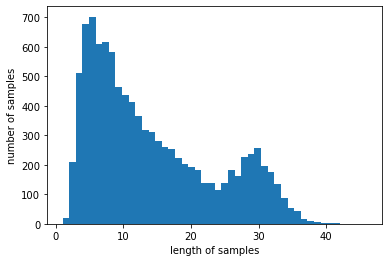

In [13]:
# 텍스트 길이 분포 보기
X_data = sequences
print('텍스트의 최대 길이 : %d' % max(len(l) for l in X_data))
print('텍스트의 최소 길이 : %d' % min(len(l) for l in X_data))
print('텍스트의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=46)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
# 패딩과 훈련 데이터, 테스트 데이터 나누기
max_len = 46
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

# 훈련 데이터와 테스트 데이터 분리

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, y_data, test_size=0.3, random_state=156)
print('train data set size = {0},  test data set size = {1}'.format(x_train.shape[0],x_test.shape[0]))
x_train[0]

훈련 데이터의 크기(shape):  (10153, 46)
train data set size = 7107,  test data set size = 3046


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1218,
       1181,   69,  100, 1646,   69,   15,  130,  868,    7,  692,   18,
       3844, 6876])

In [15]:
# LSTM 모델 만들기
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 32)) 
model.add(LSTM(32)) 
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=8, batch_size=64, validation_split=0.2)

Epoch 1/8
89/89 [==============================] - 3s 17ms/step - loss: 0.5400 - acc: 0.7402 - val_loss: 0.4208 - val_acc: 0.8439
Epoch 2/8
89/89 [==============================] - 1s 13ms/step - loss: 0.3380 - acc: 0.8777 - val_loss: 0.3436 - val_acc: 0.8594
Epoch 3/8
89/89 [==============================] - 1s 14ms/step - loss: 0.2524 - acc: 0.9075 - val_loss: 0.2751 - val_acc: 0.8924
Epoch 4/8
89/89 [==============================] - 1s 13ms/step - loss: 0.2118 - acc: 0.9237 - val_loss: 0.2947 - val_acc: 0.8931
Epoch 5/8
89/89 [==============================] - 1s 13ms/step - loss: 0.1909 - acc: 0.9302 - val_loss: 0.2746 - val_acc: 0.9001
Epoch 6/8
89/89 [==============================] - 1s 13ms/step - loss: 0.1669 - acc: 0.9402 - val_loss: 0.2754 - val_acc: 0.8931
Epoch 7/8
89/89 [==============================] - 1s 13ms/step - loss: 0.1486 - acc: 0.9472 - val_loss: 0.2809 - val_acc: 0.8931
Epoch 8/8
89/89 [==============================] - 1s 14ms/step - loss: 0.1352 - acc: 0.95

96/96 [==============================] - 0s 3ms/step - loss: 0.3627 - acc: 0.8723

 테스트 정확도: 0.8723


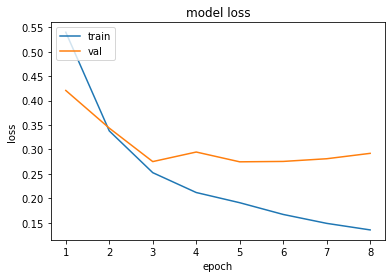

In [16]:
# 성능 평가
# 정확도 확인
print("\n 테스트 정확도: %.4f" % (model.evaluate(x_test, y_test)[1]))

# Loss 시각화
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

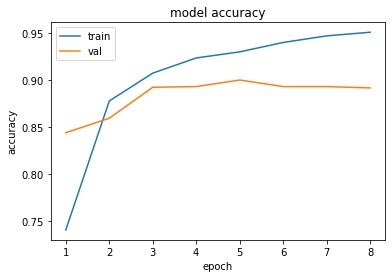

In [17]:
# 정확도 시각화 
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
data.shape

(10153, 46)

In [19]:
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,  211,    4,
        220,  105,  153,  931,  647,  453,  105,   49,  114,  153,  453,
        704,  253,  999,   49,  739,  660,    4,   94, 1752,   13, 1080,
          6,    5])

In [20]:
# 전체 데이터에 대한 감성 분석 하기

pred_result=model.predict(data)

In [21]:
pred_result

array([[0.00250217],
       [0.01526853],
       [0.02862534],
       ...,
       [0.73738515],
       [0.07909489],
       [0.33649546]], dtype=float32)

In [22]:
len(pred_result)

10153

In [23]:
pred_final=[1 if i>=0.5 else 0 for i in pred_result]

In [24]:
len(pred_final)

10153

In [25]:
review_df['sentiment_rnn']=pred_final

In [26]:
review_df

date  star   like  \
0      September 18, 2021     1   12.0   
1      September 19, 2021     1    NaN   
2      September 18, 2021     2    6.0   
3      September 18, 2021     1    2.0   
4       September 1, 2021     1  104.0   
...                   ...   ...    ...   
11275        June 6, 2019     5    NaN   
11276    November 9, 2020     5    NaN   
11277       July 17, 2020     5    NaN   
11278  September 27, 2020     1    NaN   
11279     January 1, 2021     1    NaN   

                                                 comment  \
0      This app no longer works. It has just updated ...   
1      Everything worked fine until a week or so ago....   
2      App doesn't work with wired TV connection. EDI...   
3      I'm trying this again by have Alexa connection...   
4      Just embarrassing. Absolutely, 100%, will not ...   
...                                                  ...   
11275                            Good app. useful so far   
11276           Its been helpful. Hope it stays that way   
11277  Worked like it should and gave me feedback tha...   
11278                            error routed device.. .   
11279               Not connected with washing machine 😞   

                                               comment_n  sentiment  \
0      [app, longer, work, updated, tell, login, inco...          0   
1      [everything, worked, fine, week, ago, connect,...          0   
2      [app, work, wired, tv, connection, edit, tried...          0   
3      [trying, alexa, connection, turn, lg, tv, webo...          0   
4      [embarrassing, absolutely, connect, google, ho...          0   
...                                                  ...        ...   
11275                           [good, app, useful, far]          1   
11276                         [helpful, hope, stay, way]          1   
11277            [worked, like, gave, feedback, wanting]          1   
11278                            [error, routed, device]          0   
11279                      [connected, washing, machine]          0   

                                           comment_n_str  sentiment_rnn  
0      app longer work updated tell login incorrect t...              0  
1      everything worked fine week ago connect oven a...              0  
2      app work wired tv connection edit tried app tv...              0  
3      trying alexa connection turn lg tv webos tv lg...              0  
4      embarrassing absolutely connect google home de...              0  
...                                                  ...            ...  
11275                                good app useful far              1  
11276                              helpful hope stay way              1  
11277                  worked like gave feedback wanting              1  
11278                                error routed device              0  
11279                          connected washing machine              0  

[10153 rows x 8 columns]

In [27]:
review_df.reset_index(drop=True,inplace=True)

In [28]:
aspect={'connect':['connect','connected','connection','disconnected','reconnect','network','access','link','wifi','remote','phone','call','permission','internet'],
'update':['update','updated','fix','bug','setup'],
'tv':['tv','television'],
'ac':['ac','air','conditioner','temperature'],
'washer':['washer','dryer','washing','laundry','wash'],
'refrigerator':['refrigerator','fridge','door','ice']}

In [30]:
# Aspect 관련 컬럼 만들기

result={'connect':[],'update':[],'tv':[],'ac':[],'washer':[],'refrigerator':[]}

for i in range(len(review_df)):
    comment_list=review_df.iloc[i]['comment_n'] 
    for key, list in aspect.items():
        if any(item in comment_list for item in list):
            result[key].append(1)
        else:
            result[key].append(0)

In [31]:
len(result['connect'])

10153

In [32]:
len(result['tv'])

10153

In [33]:
aspect_df=pd.DataFrame(result)

In [34]:
aspect_df

connect  update  tv  ac  washer  refrigerator
0            0       1   0   0       0             0
1            1       0   0   0       0             0
2            1       1   1   0       0             0
3            1       0   1   0       0             0
4            1       0   1   0       0             0
...        ...     ...  ..  ..     ...           ...
10148        0       0   0   0       0             0
10149        0       0   0   0       0             0
10150        0       0   0   0       0             0
10151        0       0   0   0       0             0
10152        1       0   0   0       1             0

[10153 rows x 6 columns]

In [36]:
review_df

date  star   like  \
0      September 18, 2021     1   12.0   
1      September 19, 2021     1    NaN   
2      September 18, 2021     2    6.0   
3      September 18, 2021     1    2.0   
4       September 1, 2021     1  104.0   
...                   ...   ...    ...   
10148        June 6, 2019     5    NaN   
10149    November 9, 2020     5    NaN   
10150       July 17, 2020     5    NaN   
10151  September 27, 2020     1    NaN   
10152     January 1, 2021     1    NaN   

                                                 comment  \
0      This app no longer works. It has just updated ...   
1      Everything worked fine until a week or so ago....   
2      App doesn't work with wired TV connection. EDI...   
3      I'm trying this again by have Alexa connection...   
4      Just embarrassing. Absolutely, 100%, will not ...   
...                                                  ...   
10148                            Good app. useful so far   
10149           Its been helpful. Hope it stays that way   
10150  Worked like it should and gave me feedback tha...   
10151                            error routed device.. .   
10152               Not connected with washing machine 😞   

                                               comment_n  sentiment  \
0      [app, longer, work, updated, tell, login, inco...          0   
1      [everything, worked, fine, week, ago, connect,...          0   
2      [app, work, wired, tv, connection, edit, tried...          0   
3      [trying, alexa, connection, turn, lg, tv, webo...          0   
4      [embarrassing, absolutely, connect, google, ho...          0   
...                                                  ...        ...   
10148                           [good, app, useful, far]          1   
10149                         [helpful, hope, stay, way]          1   
10150            [worked, like, gave, feedback, wanting]          1   
10151                            [error, routed, device]          0   
10152                      [connected, washing, machine]          0   

                                           comment_n_str  sentiment_rnn  
0      app longer work updated tell login incorrect t...              0  
1      everything worked fine week ago connect oven a...              0  
2      app work wired tv connection edit tried app tv...              0  
3      trying alexa connection turn lg tv webos tv lg...              0  
4      embarrassing absolutely connect google home de...              0  
...                                                  ...            ...  
10148                                good app useful far              1  
10149                              helpful hope stay way              1  
10150                  worked like gave feedback wanting              1  
10151                                error routed device              0  
10152                          connected washing machine              0  

[10153 rows x 8 columns]

In [35]:
review_df_final=pd.concat([review_df,aspect_df],axis=1)

In [36]:
review_df_final.shape

(10153, 14)

In [37]:
review_df_final

date  star   like  \
0      September 18, 2021     1   12.0   
1      September 19, 2021     1    NaN   
2      September 18, 2021     2    6.0   
3      September 18, 2021     1    2.0   
4       September 1, 2021     1  104.0   
...                   ...   ...    ...   
10148        June 6, 2019     5    NaN   
10149    November 9, 2020     5    NaN   
10150       July 17, 2020     5    NaN   
10151  September 27, 2020     1    NaN   
10152     January 1, 2021     1    NaN   

                                                 comment  \
0      This app no longer works. It has just updated ...   
1      Everything worked fine until a week or so ago....   
2      App doesn't work with wired TV connection. EDI...   
3      I'm trying this again by have Alexa connection...   
4      Just embarrassing. Absolutely, 100%, will not ...   
...                                                  ...   
10148                            Good app. useful so far   
10149           Its been helpful. Hope it stays that way   
10150  Worked like it should and gave me feedback tha...   
10151                            error routed device.. .   
10152               Not connected with washing machine 😞   

                                               comment_n  sentiment  \
0      [app, longer, work, updated, tell, login, inco...          0   
1      [everything, worked, fine, week, ago, connect,...          0   
2      [app, work, wired, tv, connection, edit, tried...          0   
3      [trying, alexa, connection, turn, lg, tv, webo...          0   
4      [embarrassing, absolutely, connect, google, ho...          0   
...                                                  ...        ...   
10148                           [good, app, useful, far]          1   
10149                         [helpful, hope, stay, way]          1   
10150            [worked, like, gave, feedback, wanting]          1   
10151                            [error, routed, device]          0   
10152                      [connected, washing, machine]          0   

                                           comment_n_str  sentiment_rnn  \
0      app longer work updated tell login incorrect t...              0   
1      everything worked fine week ago connect oven a...              0   
2      app work wired tv connection edit tried app tv...              0   
3      trying alexa connection turn lg tv webos tv lg...              0   
4      embarrassing absolutely connect google home de...              0   
...                                                  ...            ...   
10148                                good app useful far              1   
10149                              helpful hope stay way              1   
10150                  worked like gave feedback wanting              1   
10151                                error routed device              0   
10152                          connected washing machine              0   

       connect  update  tv  ac  washer  refrigerator  
0            0       1   0   0       0             0  
1            1       0   0   0       0             0  
2            1       1   1   0       0             0  
3            1       0   1   0       0             0  
4            1       0   1   0       0             0  
...        ...     ...  ..  ..     ...           ...  
10148        0       0   0   0       0             0  
10149        0       0   0   0       0             0  
10150        0       0   0   0       0             0  
10151        0       0   0   0       0             0  
10152        1       0   0   0       1             0  

[10153 rows x 14 columns]

In [38]:
aspect_list=['connect', 'update', 'tv', 'ac','washer','refrigerator']
review_df_final[aspect_list].sum()

connect         4132
update          1240
tv              1813
ac               738
washer          1748
refrigerator     573
dtype: int64

In [39]:
for key in aspect.keys():
    print(key)  # 추가함
    print(review_df_final.loc[review_df_final[key]==1,'sentiment_rnn'].sum())
    print(review_df_final.loc[review_df_final[key]==1,'sentiment_rnn'].count())

connect
732
4132
update
290
1240
tv
264
1813
ac
271
738
washer
784
1748
refrigerator
247
573


In [40]:
aspect_sent_score={}
for key in aspect.keys():
    a_sent_sum=review_df_final.loc[review_df_final[key]==1,'sentiment_rnn'].sum()
    aspect_sum=review_df_final.loc[review_df_final[key]==1,'sentiment_rnn'].count()
    aspect_score=a_sent_sum/aspect_sum
    aspect_sent_score[key]=aspect_score

In [41]:
aspect_sent_score

{'connect': 0.1771539206195547,
 'update': 0.23387096774193547,
 'tv': 0.1456150027578599,
 'ac': 0.36720867208672087,
 'washer': 0.448512585812357,
 'refrigerator': 0.43106457242582896}

In [42]:
#레이더 차트

import plotly.express as px

fig = px.line_polar(r=aspect_sent_score.values(), theta=aspect_sent_score.keys(), line_close=True,range_r=[0,0.5])
fig.update_traces(fill='toself')
fig.show()